# Attempt to correct OBCs

In [1]:
datadir = '/local/data/artemis/workspace/rdussin/OBCS_GECCO2_FIX/'

In [11]:
import numpy as np
import xarray as xr
import matplotlib.pylab as plt
from matplotlib import cm

In [7]:
%matplotlib inline

In [5]:
nxtot = 1170 # for OBC south
nytot = 1260 # for OBC east

In [3]:
fu_obc_east = datadir + 'u_GECCO_obc_east.bin'

In [6]:
data_u_in = np.fromfile(fu_obc_east,'>f')
data_u_in = np.reshape(data_u_in, [-1,50,nytot])

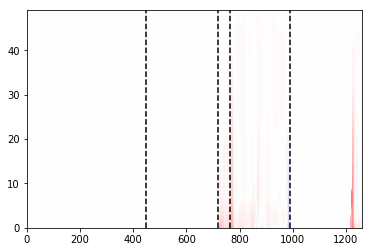

In [25]:
# the entire OBC is covering facet 1, 2, 3 and 5
plt.contourf(data_u_in[0,:,:], np.arange(-0.5,0.5,0.01), cmap=cm.bwr)
plt.plot(450 * np.ones(50), np.arange(50), 'k--') # atlantic
plt.plot(450+270 * np.ones(50), np.arange(50), 'k--') # arctic (no OBCs)
plt.plot(450+270+43 * np.ones(50), np.arange(50), 'k--') # Okhotsk
plt.plot(450+270+270 * np.ones(50), np.arange(50), 'k--') # NEP
# the end is south atlantic in last facet

In [27]:
# We need metrics
import xmitgcm
asteR1 = '/local/data/artemis/simulations/ASTE/r1/'
aste_md = xmitgcm.utils.get_extra_metadata(domain='aste', nx=270)
aste = xmitgcm.open_mdsdataset(asteR1 + 'diags/', grid_dir=asteR1 + 'grid/',
                               geometry='llc', nx=270, extra_metadata=aste_md)

In [31]:
# fortunately we are gonna work only on face 3
# we need to know the section to apply to normalize
section_surf = (aste['dyG'] * aste['drF']).sel(face=3, i_g=124)

In [32]:
section_surf

<xarray.DataArray (j: 270, k: 50)>
dask.array<shape=(270, 50), dtype=float32, chunksize=(270, 50)>
Coordinates:
    i_g      int64 124
  * j        (j) int64 0 1 2 3 4 5 6 7 8 ... 261 262 263 264 265 266 267 268 269
    face     int64 3
    dyG      (j) >f4 dask.array<shape=(270,), chunksize=(270,)>
    dxC      (j) >f4 dask.array<shape=(270,), chunksize=(270,)>
    rAw      (j) >f4 dask.array<shape=(270,), chunksize=(270,)>
    maskInW  (j) bool dask.array<shape=(270,), chunksize=(270,)>
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
    Z        (k) >f4 dask.array<shape=(50,), chunksize=(50,)>
    drF      (k) >f4 dask.array<shape=(50,), chunksize=(50,)>
    PHrefC   (k) >f4 dask.array<shape=(50,), chunksize=(50,)>

In [59]:
# Okhotsk sea goes from 0 to 42
section_surf_okh = section_surf.sel(j=slice(0,42))
# NEP does the rest
section_surf_nep = section_surf.sel(j=slice(43,270))

In [57]:
# in the numpy world
nstart_ohk = 450+270-1
nend_ohk = nstart_ohk+43

nstart_nep=nend_ohk+1
nend_nep=450+270+270

print(nstart_ohk, nend_ohk, nstart_nep, nend_nep)

719 762 763 990


In [43]:
Tr_1 = (data_u_in[:,:,nstart_ohk:nend_ohk] * section_surf_okh.values.transpose()).sum(axis=2).sum(axis=1)

In [46]:
# we want this to be zero so the easiest way is to put
data_u_out = data_u_in.copy()
data_u_out[:,:,nstart_ohk:nend_ohk] = 0.

In [60]:
Tr_2 = (data_u_in[:,:,nstart_nep:nend_nep] * section_surf_nep.values.transpose()).sum(axis=2).sum(axis=1)

In [62]:
# We want the total transport to be -1 Sv so we create a multiplication ratio
factor = -1e+6 / Tr_2

In [67]:
nt=data_u_in.shape[0]
for kt in np.arange(nt):
    data_u_out[kt,:,nstart_nep:nend_nep] = factor[kt] * data_u_in[kt,:,nstart_nep:nend_nep]

In [69]:
xmitgcm.utils.write_to_binary(data_u_out.flatten(), datadir + 'u_GECCO_obc_east_total1Sv.bin')

In [70]:
# verif

In [71]:
data_u_new = np.fromfile(datadir + 'u_GECCO_obc_east_total1Sv.bin','>f')
data_u_new = np.reshape(data_u_new, [-1,50,nytot])


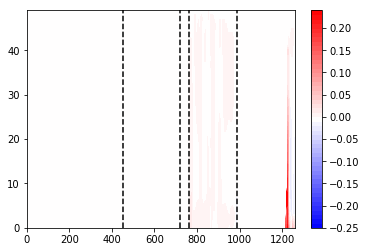

In [74]:
# the entire OBC is covering facet 1, 2, 3 and 5
plt.contourf(data_u_new[0,:,:], np.arange(-0.25,0.25,0.01), cmap=cm.bwr)
plt.colorbar()
plt.plot(450 * np.ones(50), np.arange(50), 'k--') # atlantic
plt.plot(450+270 * np.ones(50), np.arange(50), 'k--') # arctic (no OBCs)
plt.plot(450+270+43 * np.ones(50), np.arange(50), 'k--') # Okhotsk
plt.plot(450+270+270 * np.ones(50), np.arange(50), 'k--') # NEP
# the end is south atlantic in last facet

In [75]:
Tr_new = (data_u_new[:,:,nstart_nep:nend_nep] * section_surf_nep.values.transpose()).sum(axis=2).sum(axis=1)

In [77]:
Tr_new / 1e6

array([-0.99999998, -0.99999999, -1.00000005, -0.99999999, -0.99999998,
       -1.00000003, -0.99999996, -0.99999999, -0.99999998, -0.99999995,
       -1.00000001, -1.0000006 , -0.99999994, -0.99999999, -1.00000002,
       -0.99999996, -1.00000004, -0.99999998, -0.99999999, -1.00000122,
       -1.00000002, -0.99999997, -1.00000004, -1.00000004, -1.00000002,
       -1.00000004, -0.99999999, -0.99999991, -1.00000001, -0.99999996,
       -1.00000001, -0.99999999, -0.99999996, -0.99999993, -1.00000002,
       -1.00000006, -0.99999996, -1.        , -1.00000011, -1.        ,
       -1.00000002, -1.        , -1.        , -0.99999998, -1.00000005,
       -1.00000001, -1.00000001, -0.99999974, -1.        , -0.99999999,
       -1.00000045, -1.00000006, -1.        , -0.99999999, -0.99999997,
       -0.99999995, -1.00000003, -0.99999998, -0.99999996, -0.99999996,
       -1.00000002, -0.99999998, -0.99999997, -1.00000004, -1.00000002,
       -0.99999996, -1.00000006, -1.00000003, -0.99999998, -1.00